In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy.signal as signal
from scipy import interpolate
import scipy.linalg
#import gwinc
import yaml
from wield.iirrational.v2 import data2filter
from wield.control.AAA import tfAAA
from wield.utilities.file_io import load, save
from wield.control.ss_bare.ss import BareStateSpace
from scipy.signal import cheby2
from wield.control import SISO
from buzz import ssutil

# this noise spectrum is taken after the controller and before the plant

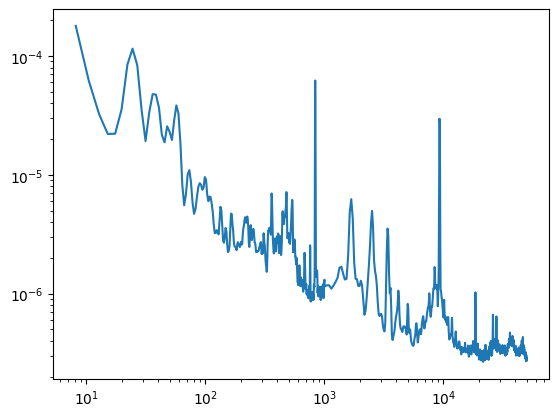

In [4]:
# Load the CSV file using numpy's genfromtxt function
high = np.genfromtxt('piezoHVSpec_highfreq_20240422_112917_Traces.csv', delimiter=',', skip_header=10).T
low = np.genfromtxt('piezoHVSpec_lowfreq_20240422_113006_Traces.csv', delimiter=',', skip_header=10).T

CLspectrum = np.concatenate((low,high),axis = 1)

plt.loglog(CLspectrum[0],CLspectrum[1])
plt.show()

In [5]:
def PIS_controller(prop_gain_dB,int_crossover,int_saturation_dB):
    int_saturation_mag = 10**(int_saturation_dB/20)
    prop_gain_mag = 10**(prop_gain_dB/20)
    return ct.tf([1,int_crossover],[1/prop_gain_mag,int_crossover/int_saturation_mag],display_format = 'zpk')
ugf_piezo_HV = 2900
pass_band_db_piezo_HV = 41.3
prop_piezo_HV = -8.0
K = PIS_controller(-8.0,2900,41.3)


[[ 1.00000000e+00+0.00000000e+00j  2.00000000e+00+0.00000000e+00j
   3.00000000e+00+0.00000000e+00j ...  4.99980000e+04+0.00000000e+00j
   4.99990000e+04+0.00000000e+00j  5.00000000e+04+0.00000000e+00j]
 [ 1.14985178e+02-1.15275660e+01j  1.11641486e+02-2.23823750e+01j
   1.06482200e+02-3.20164756e+01j ... -1.71556390e-03-8.12662302e-05j
  -1.71909901e-03-7.79378050e-05j -1.72263411e-03-7.46093798e-05j]]


c:\Users\Jeff\mambaforge\envs\buzz\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Jeff\mambaforge\envs\buzz\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


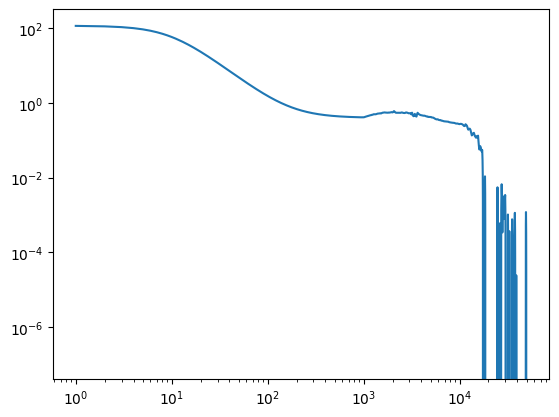

In [6]:
rawG = np.loadtxt('G_hybrid_HV.csv', delimiter=',',dtype = complex).T
print(rawG)
plt.loglog(rawG[0],rawG[1])

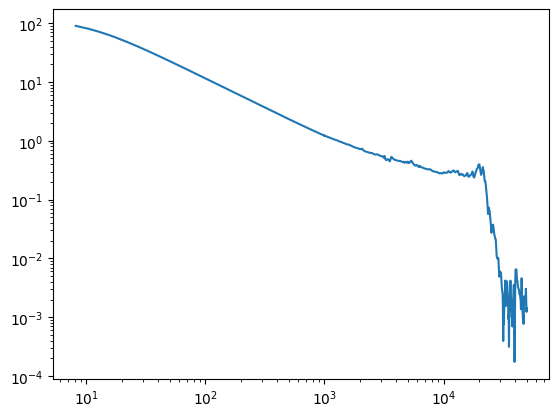

In [7]:
freq = CLspectrum[0][0:-2]
CLspec = CLspectrum[1][0:-2]

Gee = interpolate.interp1d(abs(rawG[0]),rawG[1])
G = Gee(freq)
plt.loglog(freq,abs(G))



# Now we want to remove the loop from the noise

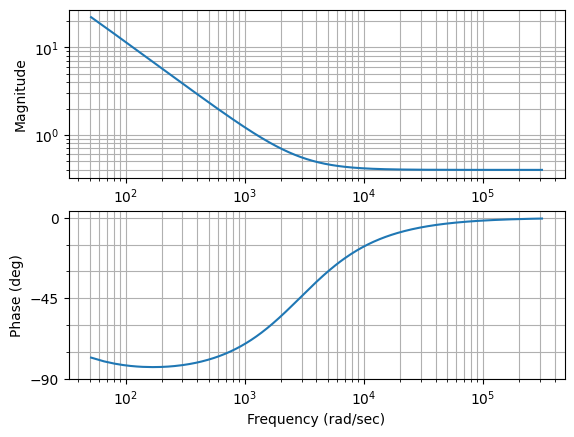

In [8]:
K_mag,K_phase,K_omega = ct.bode(K,freq*2*np.pi)
#P_mag,P_phase,P_omega = ct.bode(P.mod,freq*2*np.pi)

In [9]:
K_cmplx = K_mag*np.exp(1j*np.pi*K_phase/180)
#P_cmplx = P_mag*np.exp(1j*np.pi*P_phase/180)

CLgain = K_cmplx/(1-G)

Text(0.5, 1.0, 'open loop noise')

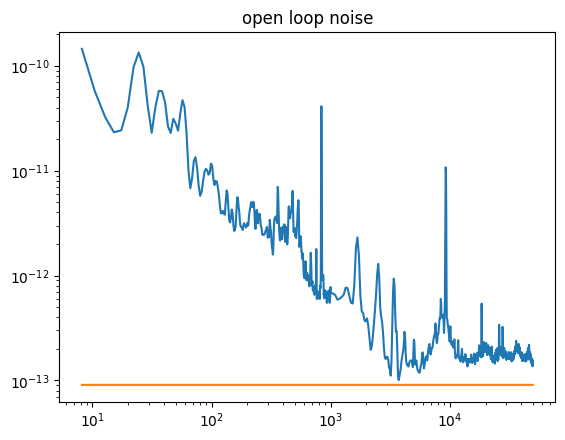

In [10]:
OLnoise = CLspec/CLgain *2.014e-7

N = len(OLnoise)
measnoise = np.ones(len(freq))* (np.min(abs(OLnoise)-1e-14))
#plt.ylim(1e-16,1e-11)
#plt.xlim(400,20000)
plt.loglog(freq,abs(OLnoise))
plt.plot(freq,measnoise)
plt.title("open loop noise")

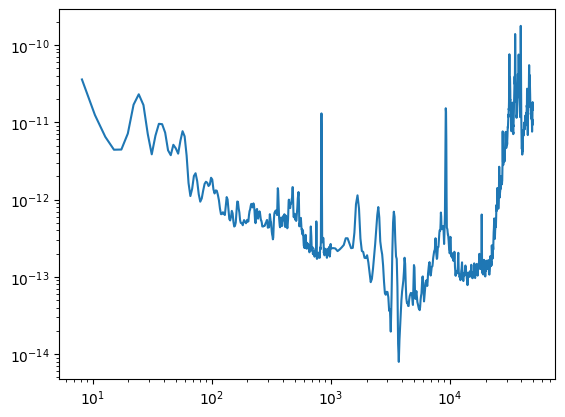

In [11]:
EP = OLnoise - measnoise
P = G/K_cmplx
E = EP/P
plt.loglog(freq,abs(E))

## We now want to fit this spectrum in the same way that we fit the plant transfer function in the last notebook

In [12]:
# edited from https://git.ligo.org/wield/wield-ligo-mcculler/-/blob/main/src/wield/LIGO/mcculler/filter_cavity/test_FC1_SUSPOINT_fits.py
def reduce(F_Hz, PSD):
    F_groups = np.geomspace(min(F_Hz), 28e3, 100) # originally 200 length
    idx_groups = np.searchsorted(F_Hz, F_groups)
    idx_pairs = list(zip(idx_groups[:-1], idx_groups[1:]))
    
    lPSDs_min = []
    lPSDs_max = []
    lPSDs_med = []
    lPSDs_mean = []
    lF_Hz = []
    for idx1, idx2 in idx_pairs:
        if idx1 == idx2:
            continue
        lPSDs_max.append(
            np.nanmax(PSD[idx1:idx2])
        )
        lPSDs_med.append(
            np.nanmedian(PSD[idx1:idx2])
        )
        lPSDs_min.append(
            np.nanmin(PSD[idx1:idx2])
        )
        lPSDs_mean.append(
            np.nanmean(PSD[idx1:idx2])
        )
        lF_Hz.append(np.mean(F_Hz[idx1:idx2]))

    return np.asarray(lF_Hz), np.asarray(lPSDs_min), np.asarray(lPSDs_med), np.asarray(lPSDs_max), np.asarray(lPSDs_mean)

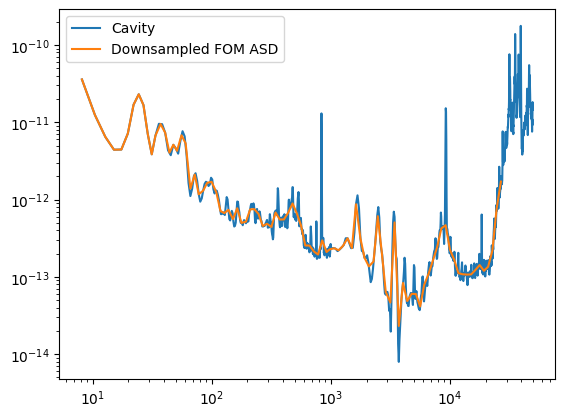

In [13]:
F_FOM_dwn, PSD_min, PSD_med, PSD_max, PSD_mean = reduce(freq,abs(E)**2)
FOM_PSD = PSD_med
FOM_ASD = FOM_PSD**0.5

plt.loglog(freq, abs(E), label = 'Cavity')
plt.loglog(F_FOM_dwn, FOM_ASD, label = 'Downsampled FOM ASD')
plt.legend()

In [14]:
results = tfAAA(F_Hz=F_FOM_dwn, xfer=abs(FOM_ASD))

In [15]:
all_z = results.zeros
all_p = results.poles
k = results.gain

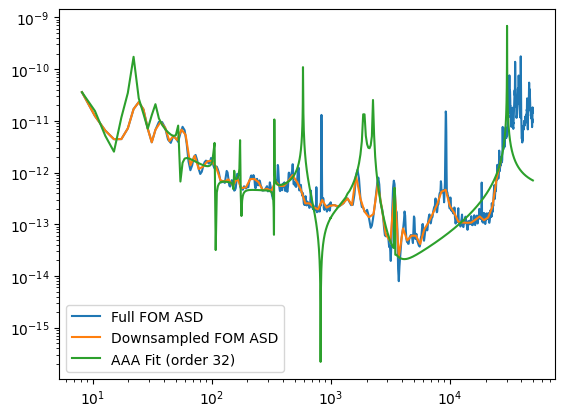

In [20]:
_, TF_all = scipy.signal.freqs_zpk(all_z, all_p, k, worN = 2*np.pi*freq)

plt.loglog(freq, abs(E), label = 'Full FOM ASD')
plt.loglog(F_FOM_dwn, abs(FOM_ASD), label = 'Downsampled FOM ASD')
#plt.loglog(freq, abs(TF_all), label = 'AAA Fit (order {})'.format(results.order))
plt.loglog(freq, abs(results(freq)), label = 'AAA Fit (order {})'.format(results.order))

plt.legend()

In [17]:
snr = np.ones_like(F_FOM_dwn)
snr[:-1] = (F_FOM_dwn[1:] - F_FOM_dwn[:-1])**-0.25

# try:
iir_results = data2filter(
    F_Hz=F_FOM_dwn,
    xfer=abs(FOM_ASD),
    mode='reduce',
    zeros=tuple(np.array(all_z) / (np.pi * 2)), 
    poles=tuple(np.array(all_p) / (np.pi * 2)),
    gain=k,
    SNR_phase_rel=0,
    SNR=snr,
    relative_degree=-4,
    # resavg_RthreshOrdDn=1.01,
    baseline_only=True,
    # coding_map=fitters_ZPK.codings_s.coding_maps.RI
    # trust_SNR = True,
)

TEE_LOGFILE None
A [-1.86470581e-07+4.82253585e+03j -1.86470581e-07-4.82253585e+03j
 -5.80301656e-12+5.47731811e+02j -5.80301656e-12-5.47731811e+02j
  4.61424952e-09+3.62422951e+02j  4.61424952e-09-3.62422951e+02j
 -8.16472195e-09+3.02319836e+02j -8.16472195e-09-3.02319836e+02j
  8.68859087e-09+2.19116660e+02j  8.68859087e-09-2.19116660e+02j
 -9.91845679e-09+9.32830630e+01j -9.91845679e-09-9.32830630e+01j
  1.50336238e-09+5.35658880e+01j  1.50336238e-09-5.35658880e+01j
 -1.49769189e-09+2.76813859e+01j -1.49769189e-09-2.76813859e+01j
 -1.10500577e-10+2.45233505e+01j -1.10500577e-10-2.45233505e+01j
 -6.42895914e-10+1.67728467e+01j -6.42895914e-10-1.67728467e+01j
 -3.95897281e-10+8.50522348e+00j -3.95897281e-10-8.50522348e+00j
  2.07017818e-11+5.13808639e-01j  2.07017818e-11-5.13808639e-01j
  2.34991402e-10+3.45254459e+00j  2.34991402e-10-3.45254459e+00j
 -2.21400077e-09+5.15511843e+00j -2.21400077e-09-5.15511843e+00j
  2.47981745e-09+4.84985837e+00j  2.47981745e-09-4.84985837e+00j]
B [  

3W   3.06  Fitter_checkpoint improvement succeed, None


------------:Q-ranked order reduction:
4P   3.35    order reduced annealing


3W   3.35    Fitter_checkpoint improvement succeed, None


5P   3.83  zero flipping, maxzp 30, residuals=4.76e+02, 1.27e+03, reldeg=-30
------------:selective order reduction:
5P   4.52    order reduced to 29, residuals=5.17e+02, reldeg=-29


3W   4.52    Fitter_checkpoint improvement succeed, None
3W   5.09    Fitter_checkpoint improvement succeed, None


5P   5.09    order reduced to 28, residuals=2.07e+02, reldeg=-28


3W   5.82    Fitter_checkpoint improvement succeed, None


5P   5.83    order reduced to 27, residuals=1.21e+02, reldeg=-27


3W   6.60    Fitter_checkpoint improvement succeed, None


5P   6.60    order reduced to 26, residuals=1.01e+01, reldeg=-26


3W   7.14    Fitter_checkpoint improvement succeed, None


5P   7.15    order reduced to 24, residuals=7.47e-01, reldeg=-24


3W   7.76    Fitter_checkpoint improvement succeed, None


5P   7.76    order reduced to 22, residuals=7.26e-01, reldeg=-22


3W   8.26    Fitter_checkpoint improvement succeed, None


5P   8.26    order reduced to 20, residuals=7.02e-01, reldeg=-20


3W   8.65    Fitter_checkpoint improvement succeed, None


5P   8.65    order reduced to 18, residuals=6.83e-01, reldeg=-18


3W   9.16    Fitter_checkpoint improvement succeed, None


5P   9.16    order reduced to 16, residuals=6.64e-01, reldeg=-16


3W   9.60    Fitter_checkpoint improvement succeed, None


5P   9.61    order reduced to 14, residuals=6.50e-01, reldeg=-14


3W   9.95    Fitter_checkpoint improvement succeed, None


5P   9.95    order reduced to 12, residuals=6.34e-01, reldeg=-12


3W  10.28    Fitter_checkpoint improvement succeed, None


5P  10.28    order reduced to 10, residuals=6.19e-01, reldeg=-10


3W  10.63    Fitter_checkpoint improvement succeed, None


5P  10.63    order reduced to 8, residuals=6.04e-01, reldeg=-8


3W  10.97    Fitter_checkpoint improvement succeed, None


5P  10.97    order reduced to 6, residuals=5.91e-01, reldeg=-6
5P  11.26    order reduced to 4, residuals=5.79e-01, reldeg=-4
2A  11.28  Baseline fit residuals: 5.79e-01, at order 4
BASELINE:  4
------------:investigations:
2I  11.30    max(z, p)       ChiSq.
                   order    avg. res.    med. res.    max. res.
             -----------  -----------  -----------  -----------
                       4      0.57865     0.358851      5.01123


3W  11.26    Fitter_checkpoint improvement succeed, None
3W  11.28  Fitter_checkpoint improvement succeed, None


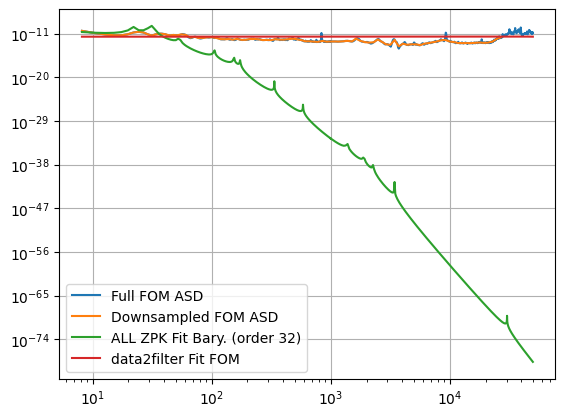

In [18]:
_, TF_all = scipy.signal.freqs_zpk(all_z, all_p, k, worN = freq)


plt.loglog(freq, abs(E), label = "Full FOM ASD")
plt.loglog(F_FOM_dwn, abs(FOM_ASD), label = "Downsampled FOM ASD")
plt.loglog(freq, abs(TF_all), label = 'ALL ZPK Fit Bary. (order {})'.format(results.order))
plt.loglog(freq, np.abs(iir_results.fitter.xfer_eval(freq)), label = "data2filter Fit FOM")
plt.grid()
plt.legend()

In [19]:
out_p = iir_results.fitter.poles.fullplane
out_z = iir_results.fitter.zeros.fullplane
out_k = iir_results.fitter.gain

# out_z = z_hand_sq
# out_p = p_hand_sq
# out_k = k_hand_sq

zpk_dict = {
            'z' : [str(zero) for zero in np.asarray(tuple(out_z)).tolist()],
            'p' : [str(pole) for pole in np.asarray(tuple(out_p)).tolist()],
            'k' : float(out_k)
            }

save('PiezoCavityPlant.yml', zpk_dict)